In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sbn
import numpy as np 

# load results 

The results file can be generated using `scripts/agg_results.py`

In [18]:
res = pd.read_csv('../../../results.csv')
res = res.assign(name=[f'model={m}_rand={bool(r)}_cag={bool(ca)}' for m,r,ca in res[['model', 'randomize', 'cell_agnostic']].values ])
res[['exp', 'repl']] = res.EXP_ID.str.split('-', 1, expand=True)
res.head()

/tmp/ipykernel_353/810473334.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  res[['exp', 'repl']] = res.EXP_ID.str.split('-', 1, expand=True)


,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,gnn,ignore_cuda,...,mse_test,mse_val,r_flat_test,r_flat_val,time_elapsed,EXP_ID,no_residual,name,exp,repl
0,50.0,0.0,32.0,mse,../output/exp4-3//proc/,cuda,0.25,100.0,GCN,0.0,...,2.112151,2.921463,0.036834,0.051780,4867.296875,exp4-3,NaN,model=gnn_rand=False_cag=False,exp4,3
1,50.0,0.0,32.0,mse,../output/exp4-3//proc/,cuda,0.25,100.0,GCN,0.0,...,2.115003,2.929343,0.005160,0.001596,4865.650391,exp4-3,NaN,model=gnn_rand=True_cag=False,exp4,3
2,50.0,0.0,5.0,mse,../output/exp4-3//proc/,cuda,0.50,100.0,NaN,0.0,...,1.847792,2.397753,0.356101,0.427370,25291.613281,exp4-3,0.0,model=gsnn_rand=False_cag=False,exp4,3
3,50.0,0.0,5.0,mse,../output/exp4-3//proc/,cuda,0.00,100.0,NaN,0.0,...,1.960955,2.569652,0.376238,0.422161,19462.087891,exp4-3,0.0,model=gsnn_rand=False_cag=False,exp4,3
4,50.0,0.0,5.0,mse,../output/exp4-3//proc/,cuda,0.25,100.0,NaN,0.0,...,1.952451,2.362255,0.335191,0.442210,21427.228516,exp4-3,0.0,model=gsnn_rand=False_cag=False,exp4,3


In [23]:
order = np.sort(res.exp.unique())
order

array(['exp1', 'exp2', 'exp3', 'exp4'], dtype=object)

In [45]:
res.columns

Index(['batch', 'cell_agnostic', 'channels', 'crit', 'data', 'device',
       'dropout', 'epochs', 'gnn', 'ignore_cuda', 'jk', 'layers', 'lr',
       'model', 'n_params', 'nonlin', 'norm', 'optim', 'out', 'randomize',
       'sched', 'siginfo', 'uid', 'wd', 'workers', 'dir_name', 'r2_test',
       'r2_val', 'r_cell_test', 'r_cell_val', 'r_drug_test', 'r_drug_val',
       'r_dose_test', 'r_dose_val', 'mse_test', 'mse_val', 'r_flat_test',
       'r_flat_val', 'time_elapsed', 'EXP_ID', 'no_residual', 'name', 'exp',
       'repl'],
      dtype='object')

# Use `test` set to choose best model within each experiment replicate

In [55]:
# metric which will choose "best" model (by max value)
metric = 'r_cell_test' ##'mse_test' #'r2_test' # 'r_flat_test'
lower_is_better = True

In [56]:
bres = res.sort_values(metric, ascending=lower_is_better).drop_duplicates(['EXP_ID', 'model', 'randomize', 'cell_agnostic'])
bres.head()

,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,gnn,ignore_cuda,...,mse_test,mse_val,r_flat_test,r_flat_val,time_elapsed,EXP_ID,no_residual,name,exp,repl
869,256.0,0.0,32.0,mse,../output/exp2-3//proc/,cpu,0.0,100.0,NaN,0.0,...,1.645615,1.786566,0.227838,0.241905,658.353577,exp2-3,NaN,model=nn_rand=False_cag=False,exp2,3
813,50.0,0.0,5.0,mse,../output/exp2-3//proc/,cuda,0.0,100.0,NaN,0.0,...,2.099549,2.283757,0.153533,0.152046,1076.376099,exp2-3,0.0,model=gsnn_rand=True_cag=False,exp2,3
274,256.0,0.0,32.0,mse,../output/exp2-1//proc/,cpu,0.5,100.0,NaN,0.0,...,1.510563,1.728723,0.243452,0.222762,603.426575,exp2-1,NaN,model=nn_rand=False_cag=False,exp2,1
524,256.0,0.0,32.0,mse,../output/exp1-2//proc/,cpu,0.5,100.0,NaN,0.0,...,1.643194,1.881785,0.263165,0.301138,590.943542,exp1-2,NaN,model=nn_rand=False_cag=False,exp1,2
636,256.0,0.0,32.0,mse,../output/exp1-1//proc/,cpu,0.5,100.0,NaN,0.0,...,1.576642,1.707022,0.319413,0.303645,440.011505,exp1-1,NaN,model=nn_rand=False_cag=False,exp1,1


# GSNN vs NN vs GNN 

Exclude `cell_agnostic` and `randomize` terms. 

Each experiment creates a unique biological input graph based on the chosen pathway (e.g., EGFR Signaling) and construcion hyperparameters and then creates the appropriate dataset of drugs, cell lines and LINCS genes. Additionally, each experiment will randomly choose unique cell-blind train/test/val splits. To mitigate data-shift issues based on random choice of train/test/val partitioning, we run each experiment 3 times, using unique splits. Within each experiment, the test set is used for a hyper-parameter grid search for optimal performance within each model type (GSNN, GNN, NN), resulting in 3 "best" models for each experiment (3 experiment replicates), and the validation set is used to report final model performances. 

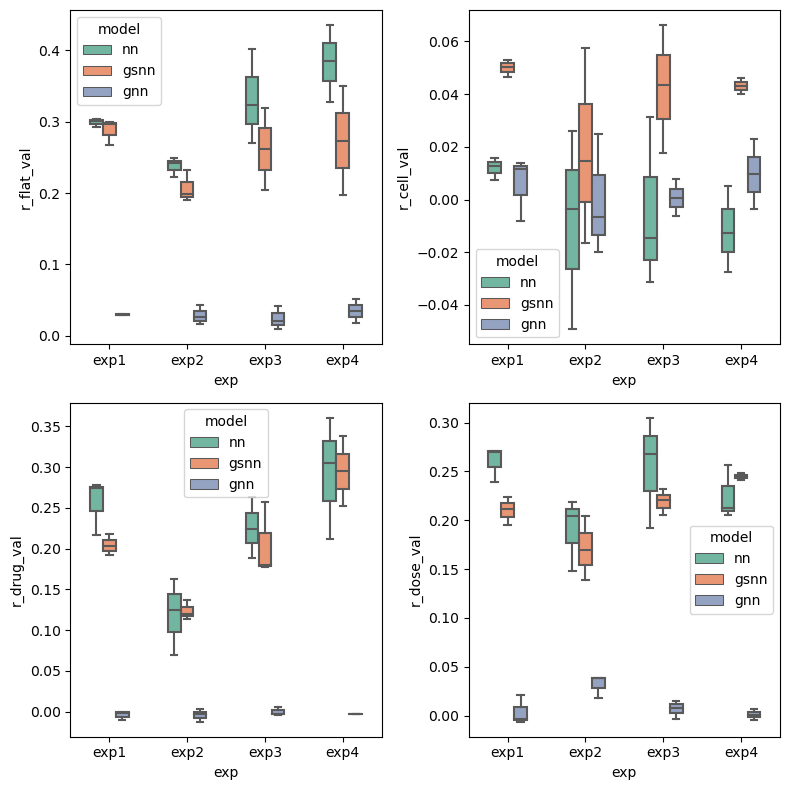

In [58]:
f,axes = plt.subplots(2,2, figsize=(8,8))
for ax, met in zip(axes.flat, ['r_flat_val', 'r_cell_val', 'r_drug_val', 'r_dose_val']):
    sbn.boxplot(x='exp', y=met, hue='model', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"), ax=ax)
plt.tight_layout()
plt.show()

# GSNN vs Randomized-GSNN

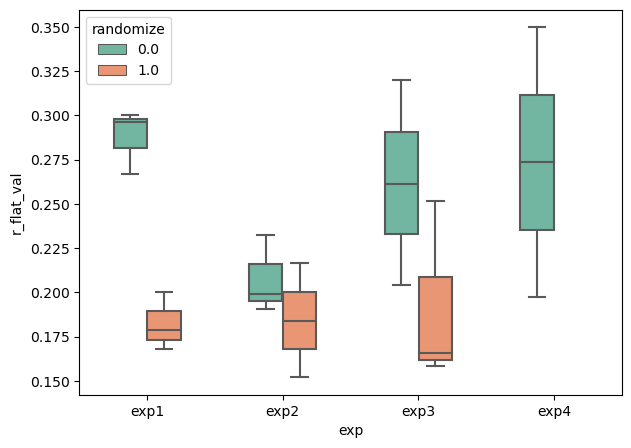

In [59]:
plt.figure(figsize=(7,5))
g = sbn.boxplot(x='exp', y='r_flat_val', hue='randomize', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.model == 'gsnn')], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
plt.show()

# `cell-agnostic` NN cell-cell performance 

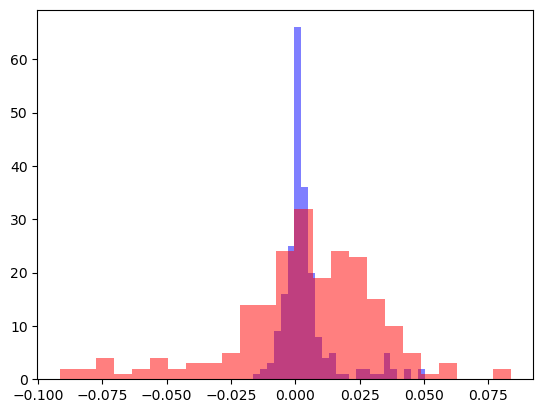

In [67]:
plt.figure()
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 1.)].r_cell_val, bins=25, color='b', alpha=0.5)
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0.)].r_cell_val, bins=25, color='r', alpha=0.5)
plt.show()

# GSNN - what hyper-parameters work best?

In [69]:
bgsnn = bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0.)]

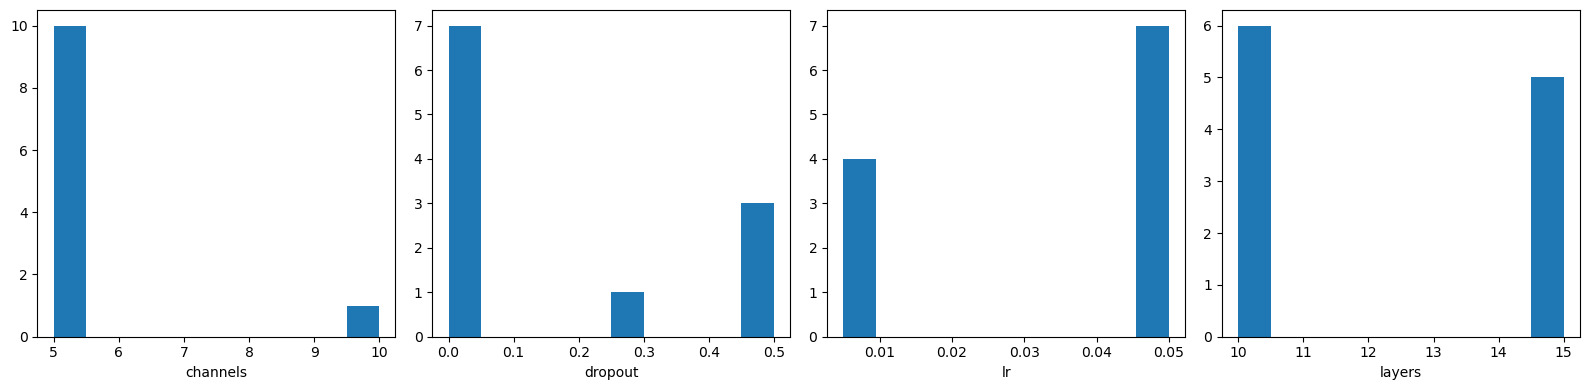

In [72]:
f, axes = plt.subplots(1,4, figsize=(4*4,4))

for ax, hp in zip(axes.flat, ['channels', 'dropout', 'lr', 'layers']): 
    ax.hist(bgsnn[hp])
    ax.set_xlabel(hp)

plt.tight_layout()
plt.show()

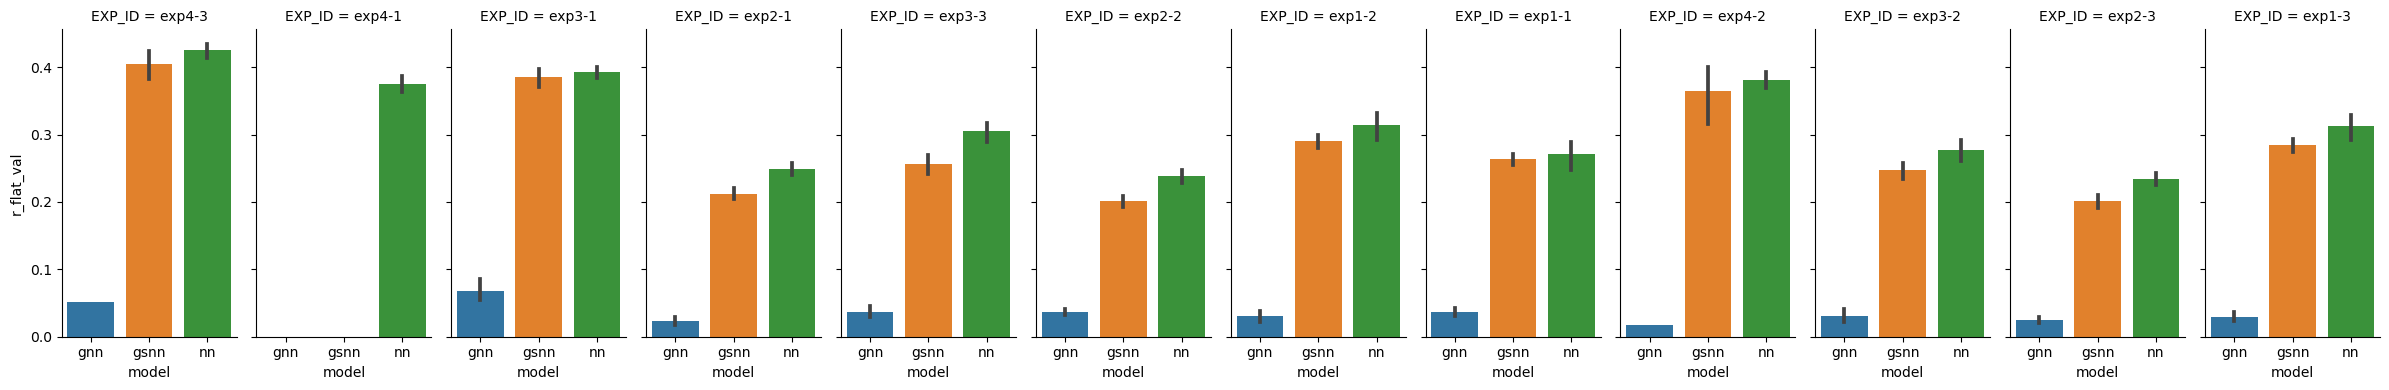

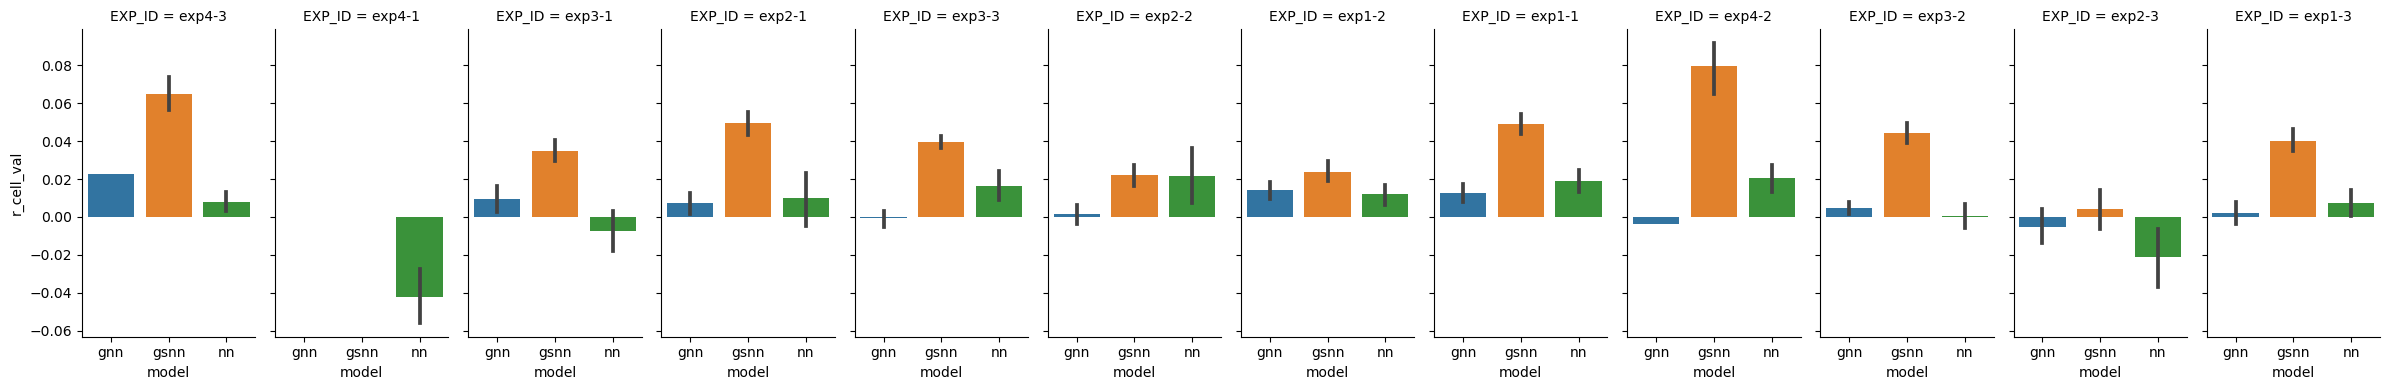

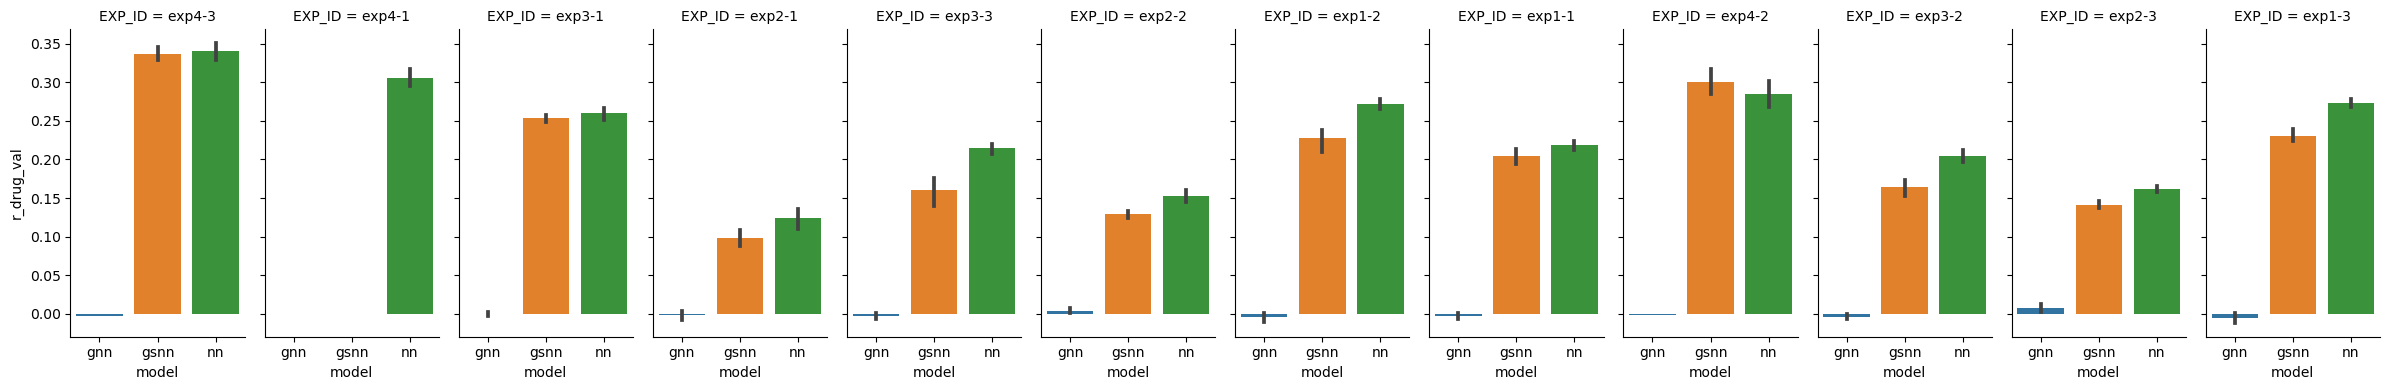

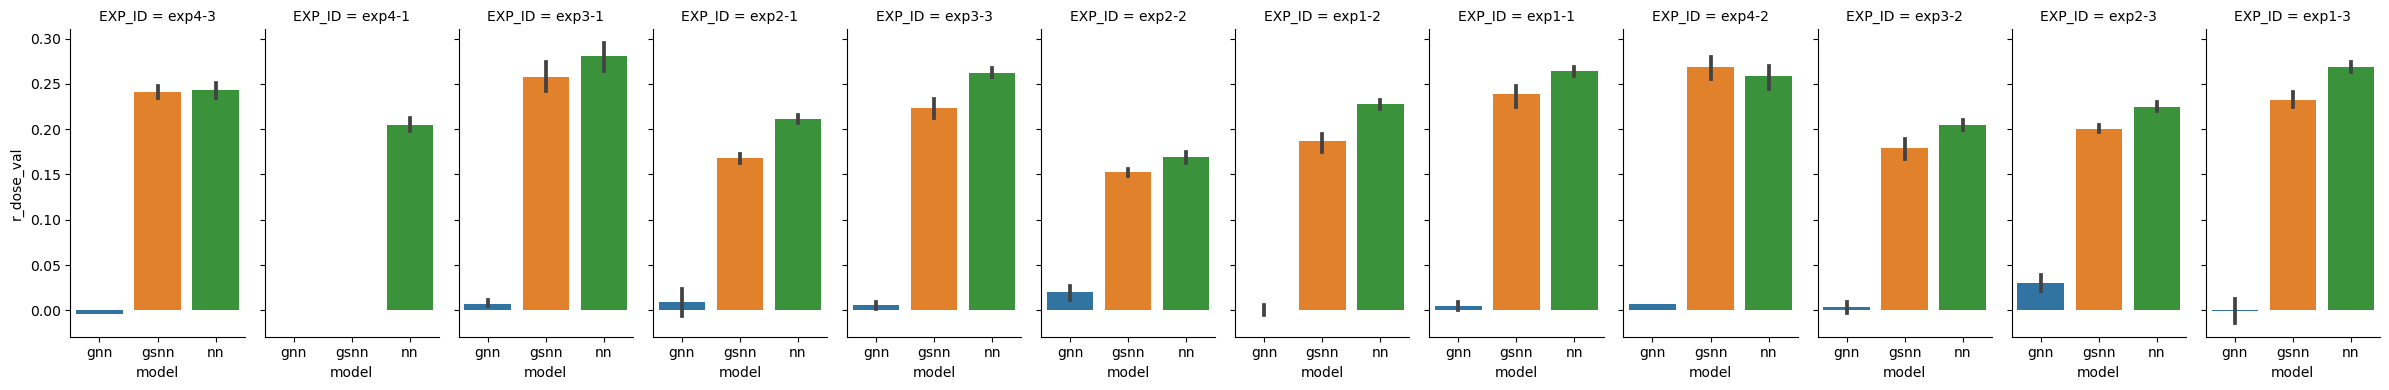

In [9]:
for i,metric in enumerate(['r_flat_val', 'r_cell_val', 'r_drug_val', 'r_dose_val']): 
    sbn.catplot(
        data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], x="model", y=metric, col="EXP_ID",
        kind="bar", height=4, aspect=.5)


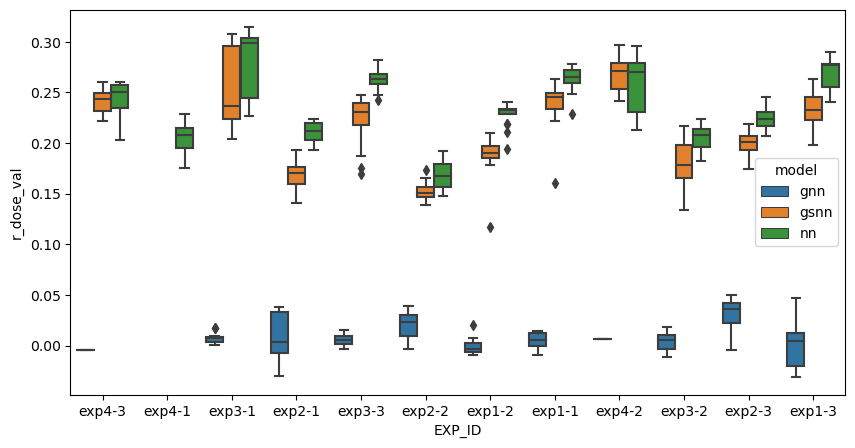

In [10]:
plt.figure(figsize=(10,5))
g = sbn.boxplot(x='EXP_ID', y=metric, hue='model', data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)])
plt.show()

# Randomized vs True network 

Compare matched hyper-parameters (`randomized` should be only difference)

In [74]:
res2 = res[lambda x: x.model == 'gsnn']
res2.groupby(list(res2.columns[~res2.columns.isin(['randomize', 'uid', 'dirname'])]))

for group in res2:
    print(group)
    break


batch


In [77]:
res['dir_name'][0]

'1abb3230-291a-4dc4-874f-3b56ce05d50a/tb/1691169503.6512825'

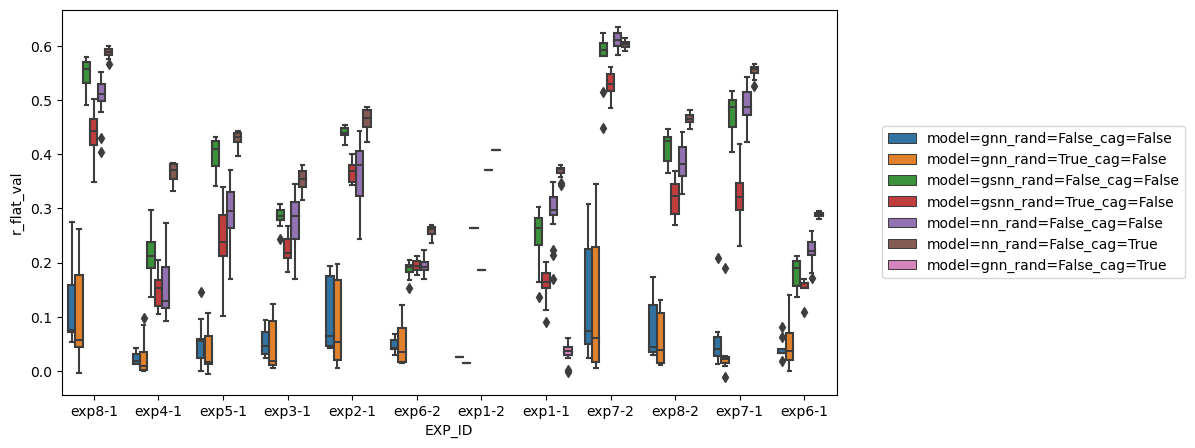

In [21]:
plt.figure(figsize=(10,5))
g = sbn.boxplot(x='EXP_ID', y='r_flat_val', hue='name', data=res)
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.show()